In [0]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# dataset_path = '/content/drive/My Drive/Colab Notebooks/MER/model_trial/dataset/CADEC.csv'
dataset_path_twitter = '/content/gdrive/My Drive/updated_annotated_data.csv'
# dataset_path_twitter = '/content/drive/My Drive/Colab Notebooks/MER/model_trial/dataset/twitter_521.csv'
BATCH_SIZE = 128  # Number of examples used in each iteration
EPOCHS = 100 #Number of passes through entire dataset
MAX_LEN = 35  # Max length of review (in words)
EMBEDDING = 200# Dimension of word embedding vector

In [30]:
data = pd.read_csv(dataset_path_twitter, names=['sec_no', 'word', 'label'], header=0)
# data = pd.read_csv(dataset_path)

# data = data.drop(['Document ID'], axis=1)

# Adding some of the twitter data in the cadec dataset to train better for the twitter data
# data = data.append(data_twitter[0:5991], ignore_index=True)
# # Remaining twitter data is for testing
# data_twitter = data_twitter[5991:]
# print(data_twitter.shape)

data = data.fillna(method="ffill")
# data_twitter = data_twitter.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['sec_no'])))
# print("Number of sentences in twitter : ", len(data_twitter.groupby(['Sentence No'])))


words = list(set(data["word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
# words_twitter = list(set(data_twitter["Word"].values))
# n_words_twitter = len(words_twitter)
# print("Number of words in the dataset: ", n_words_twitter)

tags = list(set(data["label"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data['label'].value_counts()


Number of sentences:  342204
Number of words in the dataset:  264290
Tags: ['B-Symptom', 'O', 'I-Symptom']
Number of Labels:  3
What the dataset looks like:


O            5034983
B-Symptom     352543
I-Symptom       5155
Name: label, dtype: int64

342204


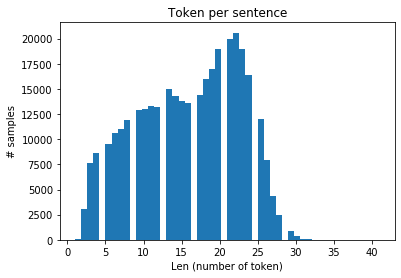

In [31]:
from random import shuffle
import random
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Tag_1), ..., (Token_n, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["label"].values.tolist())]
        self.grouped = self.data.groupby("sec_no").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
# getter_twitter = SentenceGetter(data_twitter)
sent = getter.get_next()# Get all the sentences
sentences = getter.sentences
# sentences_twitter = getter_twitter.sentences


# print(sentences_twitter)
# Shuffling the cadec and twitter dataset for better training
sentences = random.sample(sentences, len(sentences))
print(len(sentences))
sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [32]:

X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(MAX_LEN):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PAD")
    new_X.append(new_seq)

new_X[15]

# Mapping the string data to the numbers
from keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tags2index["O"])
y[15]

#------------------------------------------------------------------- with twitter data
# # Vocabulary Key:word -> Value:token_index
# # The first 2 entries are reserved for PAD and UNK
# word2idx = {w: i + 2 for i, w in enumerate(words)}
# word2idx["UNK"] = 1 # Unknown words
# word2idx["PAD"] = 0 # Padding
# word2idx
# word2idx_twitter = {w: i + 2 for i, w in enumerate(words_twitter)}
# word2idx_twitter["UNK"] = 1 # Unknown words
# word2idx_twitter["PAD"] = 0 # Padding
# word2idx_twitter




# # Vocabulary Key:token_index -> Value:word
# idx2word_twitter = {i: w for w, i in word2idx_twitter.items()}
# idx2word_twitter
# idx2word = {i: w for w, i in word2idx.items()}
# idx2word

# # Vocabulary Key:Label/Tag -> Value:tag_index
# # The first entry is reserved for PAD
# tag2idx = {t: i+1 for i, t in enumerate(tags)}
# tag2idx["PAD"] = 0
# tag2idx


# # Vocabulary Key:tag_index -> Value:Label/Tag
# idx2tag = {i: w for w, i in tag2idx.items()}
# idx2tag


# print("The word Drugs is identified by the index: {}".format(word2idx["Drug"]))
# print("The labels B-Symptom(which defines Symptom related Enitities) is identified by the index: {}".format(tag2idx["B-Symptom"]))

# from keras.preprocessing.sequence import pad_sequences
# # Convert each sentence from list of Token to list of word_index

# X = [[word2idx[w[0]] for w in s] for s in sentences]
# # Padding each sentence to have the same lenght
# X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# X_twitter = [[word2idx_twitter[w[0]] for w in s] for s in sentences_twitter]
# # Padding each sentence to have the same lenght
# X_twitter = pad_sequences(maxlen=MAX_LEN, sequences=X_twitter, padding="post", value=word2idx_twitter["PAD"])


# # Convert Tag/Label to tag_index
# y = [[tag2idx[w[1]] for w in s] for s in sentences]
# # Padding each sentence to have the same length
# y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
# from keras.utils import to_categorical
# # One-Hot encode
# y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)


# y_twitter = [[tag2idx[w[1]] for w in s] for s in sentences_twitter]
# # Padding each sentence to have the same length
# y_twitter = pad_sequences(maxlen=MAX_LEN, sequences=y_twitter, padding="post", value=tag2idx["PAD"])
# from keras.utils import to_categorical
# # One-Hot encode
# y_twitter = [to_categorical(i, num_classes=n_tags+1) for i in y_twitter]  # n_tags+1(PAD)

# from sklearn.model_selection import train_test_split
# # X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)  #this was used when CADEC was used for trraining, testing both

# X_tr, X_te = X, X_twitter
# y_tr, y_te = y, y_twitter


# X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


# # print(" sentence is : ")
# # (print(idx2word_twitter[word]) for word in sentences_twitter)

# print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
# print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
# print('Raw Sample: ', ' '.join([w[0] for w in sentences_twitter[0]]))
# print('Raw Label: ', ' '.join([w[1] for w in sentences_twitter[0]]))

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [33]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K



# new_X = new_X[:1000]
# y = y[:1000]

X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.2, random_state=2018)
print(np.array(X_tr).shape)
print(np.array(X_te).shape)

sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

BATCH_SIZE = 256
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,    tf.string)),"sequence_len": tf.constant(BATCH_SIZE*[MAX_LEN])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
input_text = Input(shape=(MAX_LEN,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(MAX_LEN, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


# --------------------------------------------------------------- with twitter data
# from keras.models import Model, Input
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from keras_contrib.layers import CRF

# # Model definition
# input = Input(shape=(MAX_LEN,))
# input
# model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
#                   input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
# model = Bidirectional(LSTM(units=50, return_sequences=True,
#                            recurrent_dropout=0.1))(model)  # variational biLSTM
# model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
# crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
# out = crf(model)  # output

# model = Model(input, out)
# model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])


# model.summary()

(273763, 35)
(68441, 35)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 35, 1024)     0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 35, 1024)     6295552     lambda_2[0][0]                   
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 35, 1024)     6295552     bidirectional_3[0][0]            
____________________________________________________________________________________________

In [34]:
l = int(len(X_tr)/BATCH_SIZE)
print(BATCH_SIZE)
print(l)
l = l-10
print(l)
l = l*BATCH_SIZE
# X_tr, X_val = X_tr[:28*BATCH_SIZE], X_tr[-3*BATCH_SIZE:]
# y_tr, y_val = y_tr[:28*BATCH_SIZE], y_tr[-3*BATCH_SIZE:]
X_trn, X_valn = X_tr[:l], X_tr[l:l+BATCH_SIZE*10]
y_trn, y_valn = y_tr[:l], y_tr[l:l+BATCH_SIZE*10]
print(len(X_trn), len(X_valn))
y_trn = y_trn.reshape(y_trn.shape[0], y_trn.shape[1], 1)
y_valn = y_valn.reshape(y_valn.shape[0], y_valn.shape[1], 1)

history = model.fit(np.array(X_trn), y_trn, validation_data = (np.array(X_valn), y_valn) ,batch_size=BATCH_SIZE, epochs=3, verbose=1)


#--------------------------------------------------------------- withh twitter data
# # history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.1, verbose=2) #this was used when CADEC was used for training, testing both
# history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.0, verbose=2)

# # Eval
# pred_cat = model.predict(X_te)
# print(pred_cat.shape)
# pred = np.argmax(pred_cat, axis=-1)
# y_te_true = np.argmax(y_te, -1)






256
1069
1059
271104 2560
Train on 271104 samples, validate on 2560 samples
Epoch 1/3
271104/271104 [==============================] - 2432s 9ms/step - loss: 0.0117 - acc: 0.9961 - val_loss: 0.0038 - val_acc: 0.9987
Epoch 2/3
271104/271104 [==============================] - 2430s 9ms/step - loss: 0.0032 - acc: 0.9989 - val_loss: 0.0028 - val_acc: 0.9992
Epoch 3/3
271104/271104 [==============================] - 2426s 9ms/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0020 - val_acc: 0.9994


In [35]:
# !pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_tes = np.array(X_te[:200*256])
print(np.array(X_trn).shape)
print(np.array(X_tes).shape)
print(np.array(X_te).shape)
test_pred = model.predict(np.array(X_tes), verbose=1, batch_size=256)

(271104, 35)
(51200, 35)
(68441, 35)
51200/51200 [==============================] - 372s 7ms/step


In [36]:
test_pred.shape

(51200, 35, 3)

In [37]:
idx2tag = {i: w for w, i in tags2index.items()}


def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
    
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)

test_labels = test2label(y_te[:200*256])
print(classification_report(test_labels, pred_labels))
print(np.array(pred_labels).shape)
print(np.array(test_labels).shape)

count = 0
total = 0
for i in range(len(test_labels)):
  if test_labels[i] == pred_labels[i]:
    count += 1
  total += 1
print(" accuracy : ",count/total)

           precision    recall  f1-score   support

  Symptom       0.98      0.99      0.99     52744

micro avg       0.98      0.99      0.99     52744
macro avg       0.98      0.99      0.99     52744

(51200, 35)
(51200, 35)
 accuracy :  0.9801953125


In [38]:
# !pip install sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report

print(flat_classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

   B-Symptom       0.98      0.99      0.99     52744
   I-Symptom       0.93      0.89      0.91       754
           O       1.00      1.00      1.00   1738502

    accuracy                           1.00   1792000
   macro avg       0.97      0.96      0.97   1792000
weighted avg       1.00      1.00      1.00   1792000



In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

In [0]:
# !pip install tensorflow

In [0]:
# !pip install keras==2.2.4

In [0]:
# !pip install sklearn-crfsuite

In [0]:
# !pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=042186aa1e059b07de5997b09b0fc3358c1046926e86316fc0323c6034b666a5
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [0]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 757kB 7.0MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
